# Datos

In [9]:
import os
import itertools

import numpy as np
import pandas as pd

import xarray as xr
import geopandas as gpd
import rioxarray
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import warnings
import matplotlib

warnings.filterwarnings( "ignore", category = pd.errors.PerformanceWarning )
warnings.filterwarnings( "ignore", category = UserWarning )

In [4]:
path_m = "../../../Datos/Mapas/"

map_dir = [ "DominioSHAPEFILE", "mun23gw", "dest23gw", "ne_10m_graticules_1" ] 
path_map = [path_m + x for x in map_dir]

# Cargamos los municipios y mapas.
mega_shp = gpd.read_file( path_map[0],
    encoding = "utf-8" ).dissolve()

# Datos y métodos

## Fig 2

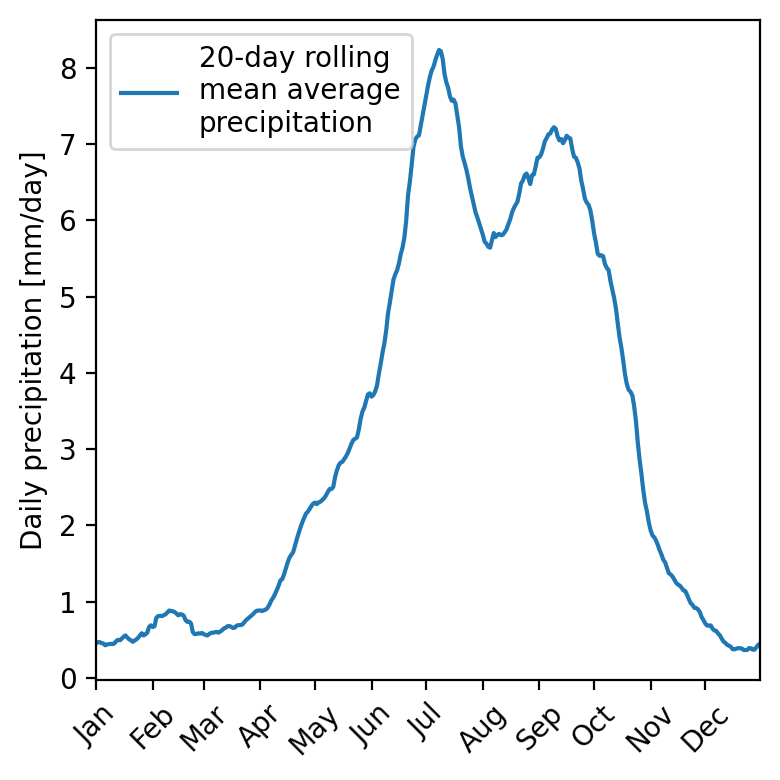

In [5]:
n = 20

f_name = ("/home/rodr/Datos/era5-land/era5-land_total-precipitation.nc")
rain = (xr.open_dataset(f_name).rename_vars({"var228": "pre"})*1000)
#rain = rain.sel({"time": rain["time"].dt.hour.isin([0])}
#    ).resample({"time":"D"}).sum()
rain = rain.resample({"time":"D"}).sum()
rain["time"] = rain["time"] - pd.Timedelta(days=1)
rain = rain.rolling({"time": n}).mean()
rain = rain.sel({"time": slice("1985","2014")})
rain = rain.rio.set_spatial_dims(
    x_dim="lon", y_dim="lat").rio.write_crs(mega_shp.crs)
rain = rain.rio.clip(mega_shp.geometry).mean(["lat", "lon"])
rain = rain.to_dataframe()[["pre"]]
rain = rain[~((rain.index.month==2)&(rain.index.day==29))]
years = rain.index.year.max() - rain.index.year.min() + 1
rain["dayofyear"] = (list(range(1, 366))*years)
rain = rain.rename(columns={"pre":
    f"{n}-day rolling\nmean average\nprecipitation"})
rain = rain.groupby("dayofyear").mean()
rain.index = pd.date_range(start="2014-01-01", end="2014-12-31", freq="D")

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(4, 4)
fig.set_dpi(200)

rain.plot(ax=ax, rot=45)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylabel("Daily precipitation [mm/day]")
ax.legend(loc="upper left")

fig.tight_layout()
plt.show()

# Resultados

# Fig 5

In [15]:
i = 7
j = 9

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "WRF_regrid_ERA5_1985_2014_qmap", "WRF_regrid_ERA5_2040_2059_qmap",
    "WRF_regrid_ERA5_2080_2089_qmap" ]

if i in [0, 1, 2]: t = ["día", "días"]
else: t = ["h", "hours"]

temp_d = "../../../temp/cc_idt/SAM/"
path_par = temp_d + name[i] + "/" + name[i] + "_idf_parametros.nc"
path_val = temp_d + name[i] + "/" + name[i] + "_idf_valores.nc" 
path_ret = temp_d + name[i] + "/" + name[i] + "_tretorno.nc" 

ds_par = xr.open_dataset(path_par)
ds_val = xr.open_dataset(path_val)
ds_ret = xr.open_dataset(path_ret)


path_par_2 = temp_d + name[j] + "/" + name[j] + "_idf_parametros.nc"
path_val_2 = temp_d + name[j] + "/" + name[j] + "_idf_valores.nc" 
path_ret_2 = temp_d + name[j] + "/" + name[j] + "_tretorno.nc" 

ds_par_2 = xr.open_dataset(path_par_2)
ds_val_2 = xr.open_dataset(path_val_2)
ds_ret_2 = xr.open_dataset(path_ret_2)

#ds_par_2["k"].values = ds_par_2["k"].values[:, ::-1]
#ds_par_2["m"].values = ds_par_2["m"].values[:, ::-1]
#ds_par_2["n"].values = ds_par_2["n"].values[:, ::-1]
#ds_par_2["c"].values = ds_par_2["c"].values[:, ::-1]
#ds_par_2["error"].values = ds_par_2["error"].values[:, ::-1]
#ds_val_2["INTENSIDAD"].values = ds_val_2["INTENSIDAD"].values[:, ::-1, :, :]
#ds_ret_2["INTENSIDAD"].values = ds_ret_2["INTENSIDAD"].values[:, ::-1, :, :]
#ds_ret_2["AÑO"].values = ds_ret_2["AÑO"].values[:, ::-1, :, :]
#ds_ret_2["PROBABILIDAD"].values = ds_ret_2["PROBABILIDAD"].values[:, ::-1, :, :]

# W: número de longitud.
# N: número de latitud.
# D: duración.
# T: tiempo de retorno.
# R: Rango de duración.
W = 10
N = 12
D = 4
T = 100
R = (1, 40)

In [16]:
# Utilizar información medida o calculada con distribución.
#RET = True
RET = False
if RET: ret = "valores medidos"
else: ret = "Wenzel formula"

# Utilizar unidades de precipitación o de intensidad.
#PRE = True
PRE = False
pre   = "mm"
p_esp = ""
if PRE:
    p_name = "Precipitación"
    p_D = D
else:
    p_name = "Rainfall intensity"
    pre   += "/" + t[0]
    p_esp += "   "
    p_D    = 1

LON = ds_ret["LONGITUD"].isel( LONGITUD = W ).values
LAT = ds_ret["LATITUD" ].isel( LATITUD  = N ).values

print(f"{LAT:.3f}°N, {LON:.3f}°W")

19.600°N, -99.200°W


In [17]:
# Calcula una intensidad con la fórmula de Wenzel.

# Función que nos genera una curva idT.
def idT(X, k, m, n, d):
    return ( k * X[0] ** m ) / ( X[1] + d ) ** n

param = ds_par.to_dataframe().loc[ ( ds_par.get_index("LONGITUD").unique()[W],
    ds_par.get_index("LATITUD").unique()[N] ) ]
param_2 = ds_par_2.to_dataframe().loc[ (
    ds_par_2.get_index("LONGITUD").unique()[W],
    ds_par_2.get_index("LATITUD").unique()[N] ) ]

print("Intensidad de precipitación obtenida con fórmula de Wenzel, 1985-2014")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.1f} {t[1]}" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( idT( (T, D), *param[:-1] ) ):5.1f} {pre}" )
print( f"Error cuadrático : {param.iloc[4]:.3f}" )
print()

print("Intensidad de precipitación obtenida con fórmula de Wenzel, 2040-2060")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.1f} {t[1]}" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( idT( (T, D), *param_2[:-1] ) ):5.1f} {pre}" )
print( f"Error cuadrático : {param_2.iloc[4]:.3f}" )

Intensidad de precipitación obtenida con fórmula de Wenzel, 1985-2014
Ubicación        : 19.600°N  -99.200°W
Duración         :   4.0 hours
Tiempo de retorno:  100  años
Rainfall intensity       :   6.1 mm/h
Error cuadrático : 10.849

Intensidad de precipitación obtenida con fórmula de Wenzel, 2040-2060
Ubicación        : 19.600°N  -99.200°W
Duración         :   4.0 hours
Tiempo de retorno:  100  años
Rainfall intensity       :  10.4 mm/h
Error cuadrático : 10.038


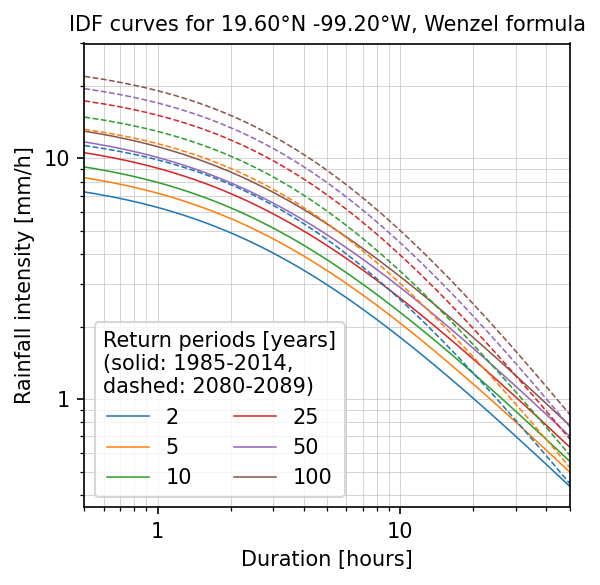

In [42]:
# Graficar todas las duraciones.

R = (0.5, 50)
delta_T = 3

if RET: 
    df_i   = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
    # Cantidad de tiempos de retorno a saltarse.
    S = 1
    df_i.columns   = [f"{x:.1f}" for x in df_i.columns]
else:
    df_i   = ds_val.isel( {"LONGITUD": W, "LATITUD": N}).to_dataframe(
        ).unstack( level = 1 )["INTENSIDAD"].transpose().iloc[:-1]
    C = df_i.columns.shape[0]
    # Cantidad de tiempos de retorno a saltarse.
    S = 1
    # Calculamos las curvas idT.
    D_i = np.linspace(*R, 1000)
    df_i.columns   = list( "A" * C )
    df_i[D_i] = None 
    df_i = df_i.iloc[:, C:]
    df_i_2 = df_i.copy()
    for i in df_i.iterrows():
        df_i.loc[ i[0] ] =  idT( (i[0], D_i), *param[:-1] )
    for i in df_i_2.iterrows():
        df_i_2.loc[ i[0] ] =  idT( (i[0], D_i), *param_2[:-1] )
    df_i = df_i.transpose()
    df_i.columns = df_i.columns.astype(int)

    df_i_2 = df_i_2.transpose()
    df_i_2.columns = df_i_2.columns.astype(int)

    df_i   = df_i[  [2, 5, 10, 25, 50, 100]]
    df_i_2 = df_i_2[[2, 5, 10, 25, 50, 100]]

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(4, 4)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_i.loc[:, :] = ( df_i.values.transpose()
        * df_i.index.values ).transpose()
    df_i_2.loc[:, :] = ( df_i_2.values.transpose()
        * df_i_2.index.values ).transpose()
ax.plot(df_i.iloc[:, ::S], linewidth=0.75)
plt.gca().set_prop_cycle(None)
ax.plot(df_i_2.iloc[:, ::S], linewidth=0.75, linestyle="--")

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.grid(which = "both", linewidth=0.25)
# Límites
ax.set_xlim(*R)
ax.set_ylim( np.floor( min(df_i.values.min(), df_i_2.values.min()) ),
             np.ceil(  max(df_i.values.max(), df_i_2.values.max())/10 ) * 10 )
# Nombre de ejes.
ax.set_xlabel(f"Duration [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend(["2", "5", "10", "25", "50", "100"],
    title="Return periods [years]\n(solid: 1985-2014,\ndashed: 2080-2089)",
    ncol=2, loc="lower left")
# Título.
ax.set_title(f"IDF curves for {LAT:.2f}°N {LON:.2f}°W, {ret}", size = 10)

fig.tight_layout()
plt.show()